In [1031]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from scipy import stats
import math
from PIL import Image
import pickle


Functions

In [1032]:
#Cleaning Data
def fill_na(df):
    df.fillna(df.median(), inplace= True)
def clean(df):
    df["sqft_basement"] = df["sqft_basement"].replace("?","0").astype(float)
    df["waterfront"] = df["waterfront"].fillna("NO")
    df["view"] = df["view"].fillna("NONE")
    df["yr_renovated"] = df["yr_renovated"].fillna(np.nan)
    df['house_age'] = df['yr_built'].map(lambda x: 2022-x)
    df["bedrooms"] = df["bedrooms"].replace(33,3)

def date_prep(df):
    df['year_sold'] = df['date'].map(lambda x: x[-4:])
    df['month'] = df['date'].map(lambda x: x[0:2])
    df['month'] = df['month'].map(lambda x: x.replace('/',''))
    df['month'] = df['month'].astype(int)
    df['year_sold'] = df['year_sold'].astype(int)

def date_bins(df):    
    bins = [0, 3, 6, 9, 12]
    date_bins = pd.cut(df['month'], bins, include_lowest=True, labels=['Winter', 'Spring', 'Summer', 'Fall'])
    date_bins = date_bins.cat.as_unordered()
    df["season"] = date_bins
    df = df.drop(["month","date"], axis = 1, inplace= True)

#Function to convert categorical data 
def convert_categorical(column_names):
    for column_name in column_names:
        df[column_name] = pd.Categorical(df[column_name])
        df[column_name] = df[column_name].cat.codes

def OLS_reg(df):
    y = df["price"]
    X = df.drop("price", axis=1)
    model = sm.OLS(y, sm.add_constant(X), missing = "drop").fit()
    results = model.summary()
    print(results)

def data_cleaning(df):
    df = df[df["price"] < 1500000]
    df = df[(np.abs(stats.zscore(df["sqft_living"])) < 3)]
    df = (df[df["bedrooms"] < 7])
    df = (df[df["bathrooms"] < 6])
    df = (df[df["sqft_living"] < 8000])

In [1033]:
#Importing Data
#Read dataset
pd.set_option('display.max_columns', None)
df1 = pd.read_csv("data/kc_house_data.csv", index_col="id")
df_income = pd.read_csv("data/dc_housing_income_by_zip.csv")#source https://www.kaggle.com/miker400/washington-state-home-mortgage-hdma2016?select=Washington_State_HDMA-2016.csv


In [1034]:
#Using median income per zipcode
income = df_income.groupby("zipcode").median().round()

In [1035]:
#Keeping last value in dataset
df1 = df1[~df1.index.duplicated(keep='last')]

In [1036]:
#Merging datasets on zipcode
df = df1.merge(income, on ="zipcode")

In [1037]:
#Exploring data
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Income
count,2.142000e+04,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000,21420.000000,17607.000000,21420.00000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000
mean,5.418614e+05,3.373950,2.118429,2083.132633,1.512804e+04,1.495985,1791.170215,1971.092997,83.890101,98077.87437,47.560197,-122.213784,1988.384080,12775.718161,144053.110317
std,3.675569e+05,0.925405,0.768720,918.808412,4.153080e+04,0.540081,828.692965,29.387141,400.534473,53.47748,0.138589,0.140791,685.537057,27345.621867,59197.423590
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.00000,47.155900,-122.519000,399.000000,651.000000,7190.000000
25%,3.249500e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1200.000000,1952.000000,0.000000,98033.00000,47.471200,-122.328000,1490.000000,5100.000000,98190.000000
50%,4.505500e+05,3.000000,2.250000,1920.000000,7.614000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.00000,47.572100,-122.230000,1840.000000,7620.000000,141286.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.069050e+04,2.000000,2220.000000,1997.000000,0.000000,98117.00000,47.678100,-122.125000,2370.000000,10086.250000,190960.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.00000,47.777600,-121.315000,6210.000000,871200.000000,277894.000000


The information above tells us waterfront, view, and  yr_renovated 

In [1038]:
#Running functions to fill numerical columns with median value
fill_na(df)

In [1039]:
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Income
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,113555.0
1,6/23/2014,205425.0,2,1.00,880,6780,1.0,NO,NONE,Good,6 Low Average,880,0.0,1945,0.0,98178,47.5009,-122.248,1190,6780,113555.0
2,7/17/2014,445000.0,3,2.25,2100,8201,1.0,NaN,AVERAGE,Average,8 Good,1620,480.0,1967,0.0,98178,47.5091,-122.244,2660,8712,113555.0
3,9/25/2014,236000.0,3,1.00,1300,5898,1.0,NaN,NONE,Average,7 Average,1300,0.0,1961,0.0,98178,47.5053,-122.255,1320,7619,113555.0
4,2/27/2015,170000.0,2,1.00,860,5265,1.0,NO,NONE,Average,6 Low Average,860,0.0,1931,0.0,98178,47.5048,-122.272,1650,8775,113555.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,10/3/2014,2720000.0,4,3.25,3990,18115,2.0,NO,NONE,Good,11 Excellent,3990,0.0,1989,0.0,98039,47.6177,-122.229,3450,16087,7190.0
21416,7/25/2014,1950000.0,4,3.50,4065,18713,2.0,NO,NONE,Good,10 Very Good,4065,0.0,1987,0.0,98039,47.6209,-122.237,3070,18713,7190.0
21417,4/21/2015,2250000.0,5,5.25,3410,8118,2.0,NaN,NONE,Average,11 Excellent,3410,0.0,2006,0.0,98039,47.6295,-122.236,3410,16236,7190.0
21418,11/13/2014,2900000.0,5,4.00,5190,14600,2.0,NO,FAIR,Average,11 Excellent,5190,0.0,2013,0.0,98039,47.6102,-122.225,3840,19250,7190.0


In [1040]:
#Running functions to change date to usable format and bin dates into seasons
date_prep(df)
date_bins(df)

In [1041]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Income,year_sold,season
0,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,113555.0,2014,Fall
1,205425.0,2,1.00,880,6780,1.0,NO,NONE,Good,6 Low Average,880,0.0,1945,0.0,98178,47.5009,-122.248,1190,6780,113555.0,2014,Spring
2,445000.0,3,2.25,2100,8201,1.0,NaN,AVERAGE,Average,8 Good,1620,480.0,1967,0.0,98178,47.5091,-122.244,2660,8712,113555.0,2014,Summer
3,236000.0,3,1.00,1300,5898,1.0,NaN,NONE,Average,7 Average,1300,0.0,1961,0.0,98178,47.5053,-122.255,1320,7619,113555.0,2014,Summer
4,170000.0,2,1.00,860,5265,1.0,NO,NONE,Average,6 Low Average,860,0.0,1931,0.0,98178,47.5048,-122.272,1650,8775,113555.0,2015,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,2720000.0,4,3.25,3990,18115,2.0,NO,NONE,Good,11 Excellent,3990,0.0,1989,0.0,98039,47.6177,-122.229,3450,16087,7190.0,2014,Fall
21416,1950000.0,4,3.50,4065,18713,2.0,NO,NONE,Good,10 Very Good,4065,0.0,1987,0.0,98039,47.6209,-122.237,3070,18713,7190.0,2014,Summer
21417,2250000.0,5,5.25,3410,8118,2.0,NaN,NONE,Average,11 Excellent,3410,0.0,2006,0.0,98039,47.6295,-122.236,3410,16236,7190.0,2015,Spring
21418,2900000.0,5,4.00,5190,14600,2.0,NO,FAIR,Average,11 Excellent,5190,0.0,2013,0.0,98039,47.6102,-122.225,3840,19250,7190.0,2014,Fall


In [1042]:
#Saving changed to csv
df.to_csv("data/kc_house_data_no_miss_values.csv")

In [1043]:
df.dtypes

price             float64
bedrooms            int64
bathrooms         float64
sqft_living         int64
sqft_lot            int64
floors            float64
waterfront         object
view               object
condition          object
grade              object
sqft_above          int64
sqft_basement      object
yr_built            int64
yr_renovated      float64
zipcode             int64
lat               float64
long              float64
sqft_living15       int64
sqft_lot15          int64
Income            float64
year_sold           int32
season           category
dtype: object

In [1044]:
#Converting sqft_basement to float
df["sqft_basement"] = df["sqft_basement"].replace("?","0").astype(float)

In [1045]:
convert_categorical(["bedrooms","bathrooms","floors","waterfront","view","condition","season","grade"])

In [1046]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Income,year_sold,season
0,221900.0,2,2,1180,5650,0,-1,4,0,8,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,113555.0,2014,3
1,205425.0,1,2,880,6780,0,0,4,2,7,880,0.0,1945,0.0,98178,47.5009,-122.248,1190,6780,113555.0,2014,1
2,445000.0,2,7,2100,8201,0,-1,0,0,9,1620,480.0,1967,0.0,98178,47.5091,-122.244,2660,8712,113555.0,2014,2
3,236000.0,2,2,1300,5898,0,-1,4,0,8,1300,0.0,1961,0.0,98178,47.5053,-122.255,1320,7619,113555.0,2014,2
4,170000.0,1,2,860,5265,0,0,4,0,7,860,0.0,1931,0.0,98178,47.5048,-122.272,1650,8775,113555.0,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,2720000.0,3,11,3990,18115,2,0,4,2,1,3990,0.0,1989,0.0,98039,47.6177,-122.229,3450,16087,7190.0,2014,3
21416,1950000.0,3,12,4065,18713,2,0,4,2,0,4065,0.0,1987,0.0,98039,47.6209,-122.237,3070,18713,7190.0,2014,2
21417,2250000.0,4,19,3410,8118,2,-1,4,0,1,3410,0.0,2006,0.0,98039,47.6295,-122.236,3410,16236,7190.0,2015,1
21418,2900000.0,4,14,5190,14600,2,0,2,0,1,5190,0.0,2013,0.0,98039,47.6102,-122.225,3840,19250,7190.0,2014,3


In [1047]:
first_model = OLS_reg(df)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     1998.
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        22:38:56   Log-Likelihood:            -2.9326e+05
No. Observations:               21420   AIC:                         5.866e+05
Df Residuals:                   21398   BIC:                         5.867e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.476e+07   9.95e+06     -7.514

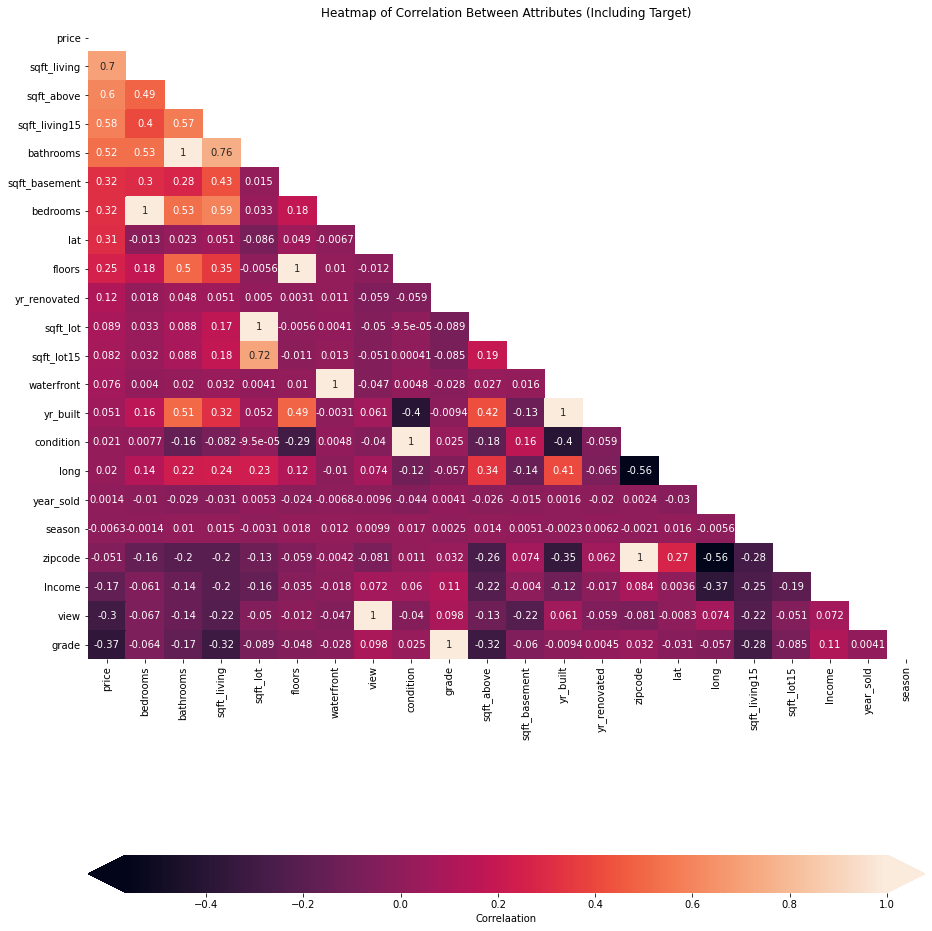

In [1048]:
initial_corr = df.corr().sort_values(by="price", ascending=False)
fig, ax = plt.subplots(figsize=(15,18))
sns.heatmap(data = initial_corr, mask = np.triu(np.ones_like(initial_corr, dtype=bool)), ax = ax, annot = True, cbar_kws = {"label": "Correlaation", "orientation": "horizontal", "pad": .2, "extend": "both"})

ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [1049]:
high_corr_formula = 'price ~ sqft_living'
high_corr_formula = ols(formula=high_corr_formula, data=df).fit()
singular_model = high_corr_formula.summary()
print(singular_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 2.073e+04
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        22:38:58   Log-Likelihood:            -2.9763e+05
No. Observations:               21420   AIC:                         5.953e+05
Df Residuals:                   21418   BIC:                         5.953e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.255e+04   4436.470     -9.591      

In [1050]:
OLS_reg(df)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     1998.
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        22:38:58   Log-Likelihood:            -2.9326e+05
No. Observations:               21420   AIC:                         5.866e+05
Df Residuals:                   21398   BIC:                         5.867e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.476e+07   9.95e+06     -7.514

In [1072]:
y = df["price"]
X = df.drop("price", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
lm = LinearRegression().fit(X_train, y_train)
lm_dummy_median = DummyRegressor(strategy = 'median').fit(X_train, y_train)
y_predict = lm.predict(X_test)
y_predict_dummy_median = lm_dummy_median.predict(X_test)
y_predict_dummy_median
#y_predict_dummy_median.score(X, y, sample_weight=None)
lm_dummy_median.score(X_test, y_test)


-0.050963166486287736

sns.pairplot(df, y_vars="price")

As we can see from the charts there are some outliers that need to be addressed, after the outliers are addressed we will also need to log tranform some of our data to turn into normal distribution

<AxesSubplot:>

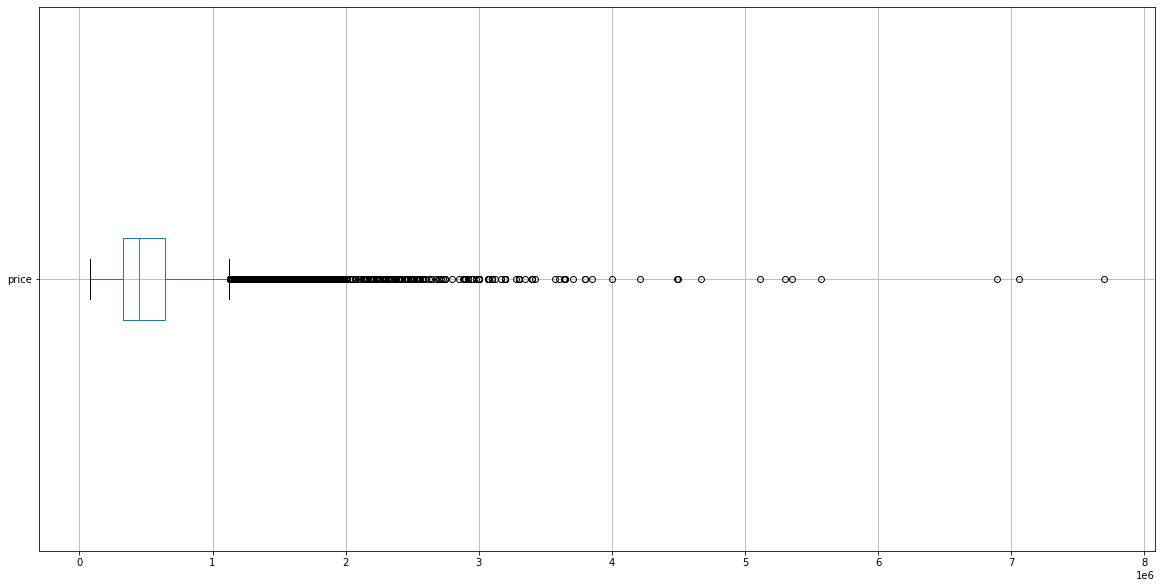

In [1053]:
df.boxplot('price', vert=False, figsize=(20,10))

In [1054]:
df = df[df["price"] < 1500000]

<AxesSubplot:>

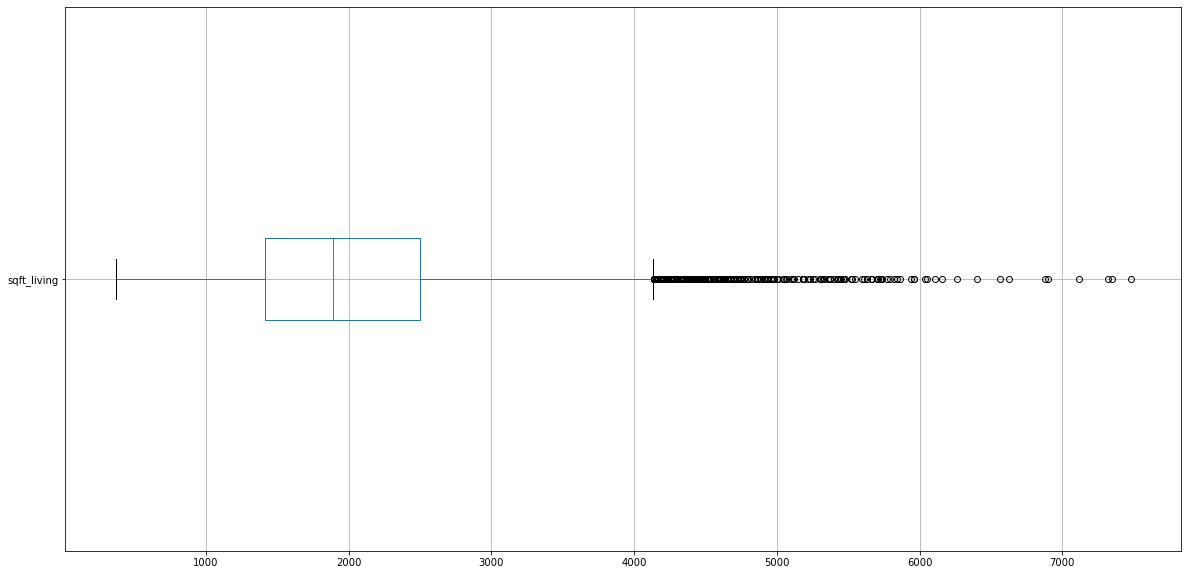

In [1055]:
df.boxplot('sqft_living', vert=False, figsize=(20,10))

In [1056]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Income,year_sold,season
0,221900.0,2,2,1180,5650,0,-1,4,0,8,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,113555.0,2014,3
1,205425.0,1,2,880,6780,0,0,4,2,7,880,0.0,1945,0.0,98178,47.5009,-122.248,1190,6780,113555.0,2014,1
2,445000.0,2,7,2100,8201,0,-1,0,0,9,1620,480.0,1967,0.0,98178,47.5091,-122.244,2660,8712,113555.0,2014,2
3,236000.0,2,2,1300,5898,0,-1,4,0,8,1300,0.0,1961,0.0,98178,47.5053,-122.255,1320,7619,113555.0,2014,2
4,170000.0,1,2,860,5265,0,0,4,0,7,860,0.0,1931,0.0,98178,47.5048,-122.272,1650,8775,113555.0,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21398,1260000.0,2,8,3110,9930,0,0,2,0,9,1640,1470.0,1954,0.0,98039,47.6112,-122.226,3650,14399,7190.0,2014,2
21404,1200000.0,3,10,2150,8119,2,0,4,0,9,2150,0.0,1953,2004.0,98039,47.6335,-122.236,1590,8119,7190.0,2015,1
21407,1450000.0,4,9,3090,19865,0,0,4,2,10,3090,0.0,1953,0.0,98039,47.6232,-122.235,2970,19862,7190.0,2014,3
21410,1350000.0,2,6,2070,9600,0,0,2,0,8,1590,480.0,1946,0.0,98039,47.6160,-122.239,3000,16215,7190.0,2014,2


In [1057]:
df = df[(np.abs(stats.zscore(df["sqft_living"])) < 3)]

<AxesSubplot:>

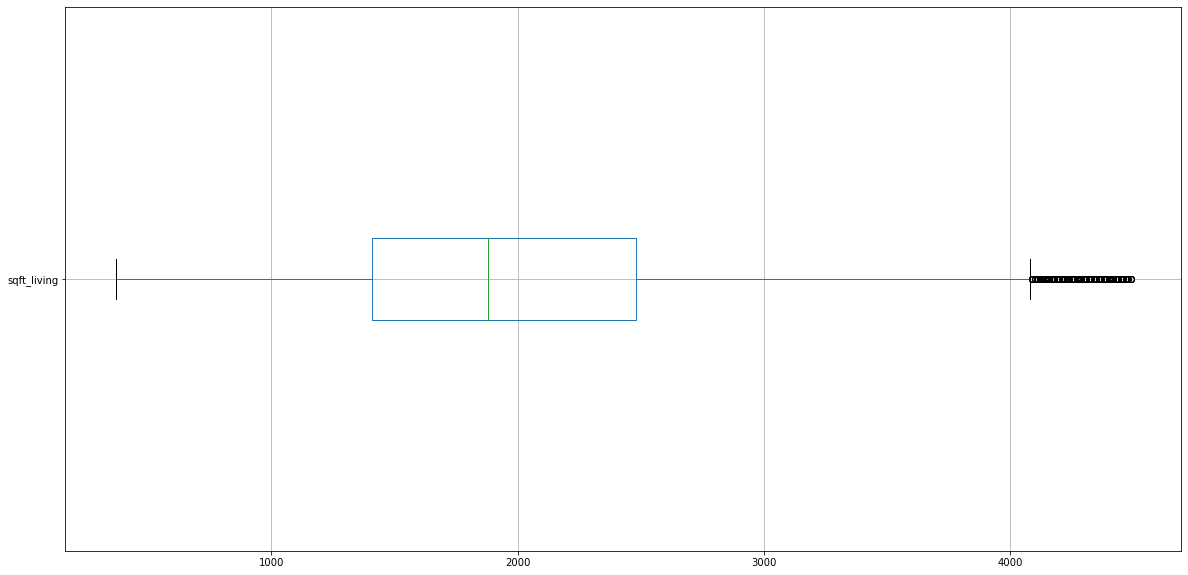

In [1058]:
df.boxplot('sqft_living', vert=False, figsize=(20,10))

<AxesSubplot:>

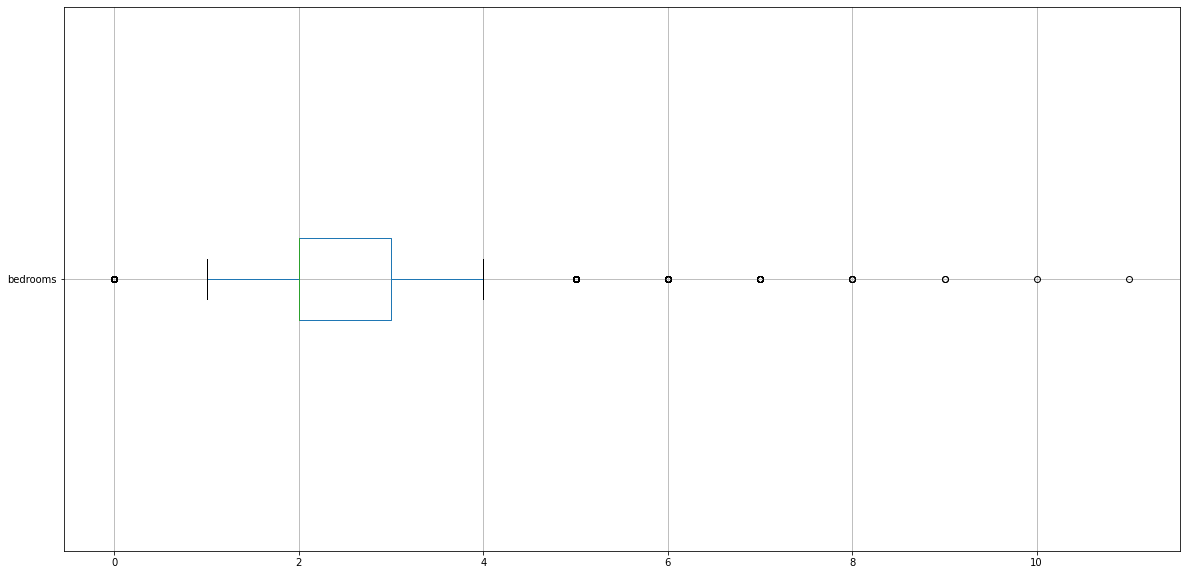

In [1059]:
df.boxplot('bedrooms', vert=False, figsize=(20,10))

In [1060]:
df = (df[df["bedrooms"] < 7])

<AxesSubplot:>

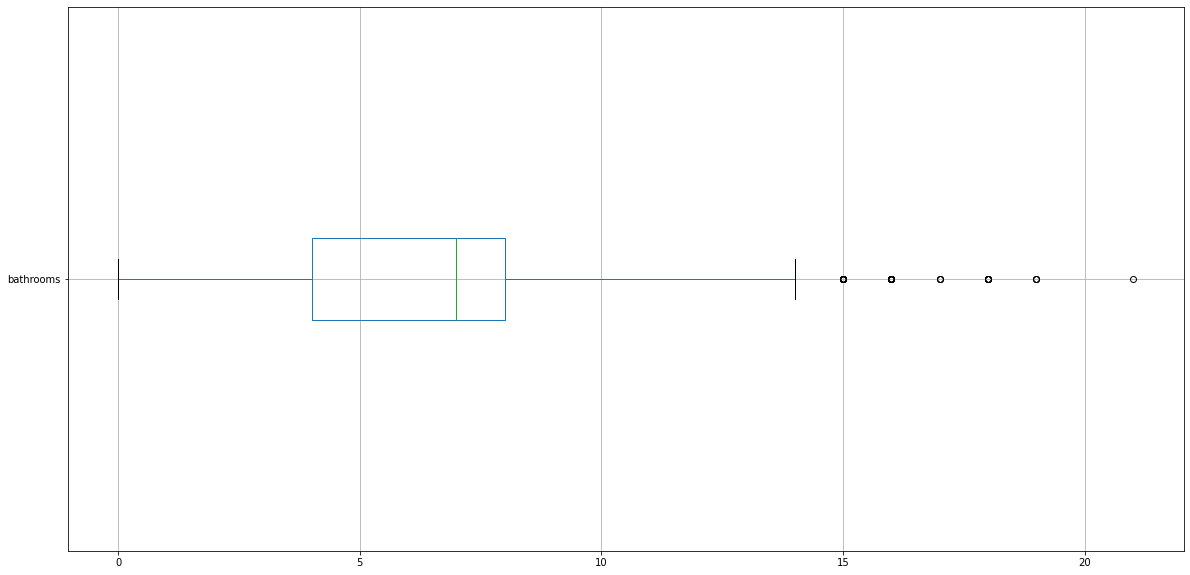

In [1061]:
df.boxplot('bathrooms', vert=False, figsize=(20,10))

In [1062]:
df = (df[df["bathrooms"] < 15])


In [1063]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Income,year_sold,season
count,2.060200e+04,20602.000000,20602.000000,20602.000000,2.060200e+04,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000,20602.000000
mean,4.953211e+05,2.329483,6.227065,1988.832977,1.442505e+04,0.961751,-0.106495,3.746578,0.855111,8.009368,1718.245559,264.912533,1970.754344,63.838220,98078.573925,47.558521,-122.214397,1938.146927,12307.690952,145243.577128,2014.325066,1.523007
std,2.388506e+05,0.863913,2.774538,765.304281,3.912709e+04,1.075696,0.319454,0.905942,1.264621,2.007113,722.081119,406.915370,29.283278,351.203133,53.403873,0.140089,0.141573,624.802711,25449.335961,59136.609408,0.468411,1.034936
min,7.800000e+04,0.000000,0.000000,370.000000,5.200000e+02,0.000000,-1.000000,-1.000000,0.000000,0.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,7190.000000,2014.000000,0.000000
25%,3.199500e+05,2.000000,4.000000,1410.000000,5.000000e+03,0.000000,0.000000,4.000000,0.000000,8.000000,1180.000000,0.000000,1951.000000,0.000000,98033.000000,47.465025,-122.330000,1480.000000,5040.000000,98510.000000,2014.000000,1.000000
50%,4.425000e+05,2.000000,7.000000,1880.000000,7.500000e+03,0.000000,0.000000,4.000000,0.000000,8.000000,1530.000000,0.000000,1974.000000,0.000000,98065.000000,47.569500,-122.233000,1820.000000,7533.000000,141286.000000,2014.000000,1.000000
75%,6.180000e+05,3.000000,8.000000,2460.000000,1.035000e+04,2.000000,0.000000,4.000000,2.000000,9.000000,2120.000000,510.000000,1996.000000,0.000000,98118.000000,47.679200,-122.125000,2300.000000,9900.000000,190960.000000,2015.000000,2.000000
max,1.490000e+06,6.000000,14.000000,4490.000000,1.651359e+06,5.000000,1.000000,4.000000,4.000000,10.000000,4480.000000,2220.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,560617.000000,277894.000000,2015.000000,3.000000


In [1064]:
second_model = OLS_reg(df)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     1821.
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        22:39:00   Log-Likelihood:            -2.7354e+05
No. Observations:               20602   AIC:                         5.471e+05
Df Residuals:                   20580   BIC:                         5.473e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -6.14e+07   6.72e+06     -9.140

In [1073]:
def predictive_model(df):
    df2 = df.to_numpy()
    y1 = df2[:, 0]
    X1 = df2[:,1:]
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)
    data_transformation = preprocessing.StandardScaler()
    data = data_transformation.fit_transform(X_train1)
    model = LinearRegression().fit(data, y_train1)
    accuracy = model.score(data, y_train1)
    test_accuracy = model.score(data_transformation.transform((X_test1)), y_test1)
    y_pred = model.predict(data_transformation.transform(X_test1))
    print(X_train1.shape)
    print(X_test1.shape)
    print(y_train1.shape)
    print(y_test1.shape)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test1, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test1, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test1, y_pred)))

In [1074]:
predictive_model(df)

(16481, 21)
(4121, 21)
(16481,)
(4121,)


NameError: name 'metrics' is not defined